In [1]:
from fastai2.vision.all import *

In [2]:
path = untar_data(URLs.PETS)
path.ls()

(#2) [Path('/home/heye0507/.fastai/data/oxford-iiit-pet/annotations'),Path('/home/heye0507/.fastai/data/oxford-iiit-pet/images')]

Transform like pytorch Dataset, TfmdDL is dataloaders

ItemTransform V.S. Transform, setup state inside setup function for ItemTransform, Transform has to setup state outside of the class

In [3]:
fnames = get_image_files(path/'images')
fnames[0:3]

(#3) [Path('/home/heye0507/.fastai/data/oxford-iiit-pet/images/pomeranian_81.jpg'),Path('/home/heye0507/.fastai/data/oxford-iiit-pet/images/British_Shorthair_56.jpg'),Path('/home/heye0507/.fastai/data/oxford-iiit-pet/images/japanese_chin_102.jpg')]

In [5]:
lbl_func = RegexLabeller(pat=r'^(.*)_\d+.jpg$')
lbl_func(fnames[0].name)

'pomeranian'

Wrap it

In [25]:
img_1.size < img_2.size

False

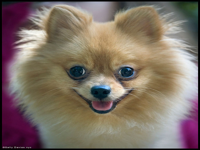

In [28]:
img_1.resize(img_2.size)

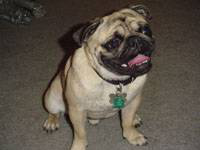

In [29]:
img_2

In [40]:
class SiameseImage(Tuple):
    def show(self,ctx=None, **kwargs):
        if len(self) > 2:
            img_1,img_2,similarity = self
        else:
            img_1,img_2 = self
            similarity = 'Unknown'
        if not isinstance(img_1,Tensor):
            if img_1.size < img_2.size:
               img_1 = img_1.resize(img_2.size)
            elif img_1.size > img_2.size:
                img_2 = img_2.resize(img_1.size)
            t_img_1 = tensor(img_1).permute(2,0,1)
            t_img_2 = tensor(img_2).permute(2,0,1)
        else:
            t_img_1, t_img_2 = img_1, img_2
        line = t_img_1.new_zeros((t_img_1.shape[0],t_img_1.shape[1],10))
        return show_image(torch.cat((t_img_1,line,t_img_2),dim=2),title=similarity,ctx=ctx,**kwargs)
    


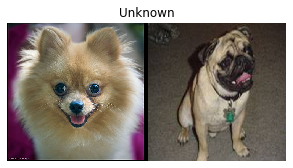

In [44]:
img_1 = PILImage.create(fnames[0])
img_2 = PILImage.create(fnames[400])
s = SiameseImage(img_1,img_2)
s.show()

In [45]:
t = ['1','2','3']
random.choice(t)

'2'

In [61]:
class SiameseTransform(Transform):
    def __init__(self,fnames,splits):
        self.labels = list(set(fnames.map(self._label_func)))
        self._init_label_file_lookup(fnames,splits) # self.label_file_table, self.train_file_table
        self._init_valid(fnames,splits)
        
    def encodes(self,f):
        if f in self.valid:
            f2,same = self.valid[f]
        else:
            f2,same = self._draw(f,self.train_file_table) 
        img_1, img_2 = PILImage.create(f), PILImage.create(f2)
        return SiameseImage(img_1,img_2,same)


    def _label_func(self,fname):
        return RegexLabeller(pat=r'^(.*)_\d+.jpg$')(Path(fname).name)
    
    def _init_label_file_lookup(self,fnames,splits):
        self.label_file_table = collections.defaultdict(list) # total file table, it doesnt matter if valid draws train for Siamese pair
        self.train_file_table = collections.defaultdict(list) # train file table, it matters if train draws valid for Siamese pair
        for f in fnames:
            label = self._label_func(f)
            self.label_file_table[label].append(f)
        for f in fnames[splits[0]]:
            label = self._label_func(f)
            self.train_file_table[label].append(f)
    
    def _init_valid(self,fnames,splits):
        idx = splits[1]
        self.valid = {}
        for f in fnames[idx]:
            self.valid[f] = self._draw(f,self.label_file_table)
    
    def _draw(self,fname,lookup_table):
        same = random.random() < 0.5
        target_class = self._label_func(fname)
        if not same:
            target_class = random.choice([l for l in self.labels if l != target_class])
        return random.choice(lookup_table[target_class]),same

        



In [57]:
splits = RandomSplitter()(fnames)
len(splits)

2

In [62]:
tfm = SiameseTransform(fnames, splits)

In [65]:
tls = TfmdLists(fnames,tfm,splits=splits)

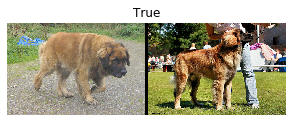

In [79]:
tls.valid[23].show()

In [80]:
dls = tls.dataloaders(
    after_item=[Resize(224),ToTensor],
    after_batch=[IntToFloatTensor,Normalize.from_stats(*imagenet_stats)]
)

In [81]:
b = dls.one_batch()

In [93]:
['a','b'][1]

'b'

In [84]:

@typedispatch
def show_batch(x:SiameseImage, y, samples, ctxs=None, max_n=6, nrows=None, ncols=2, figsize=None, **kwargs):
    if figsize is None: figsize = (ncols*6, max_n//ncols * 3)
    if ctxs is None: ctxs = get_grid(min(x[0].shape[0], max_n), nrows=None, ncols=ncols, figsize=figsize)
    for i,ctx in enumerate(ctxs): SiameseImage(x[0][i], x[1][i], ['Not similar','Similar'][x[2][i].item()]).show(ctx=ctx)

In [85]:
dls._types

{__main__.SiameseImage: [fastai2.torch_core.TensorImage,
  fastai2.torch_core.TensorImage,
  torch.Tensor]}

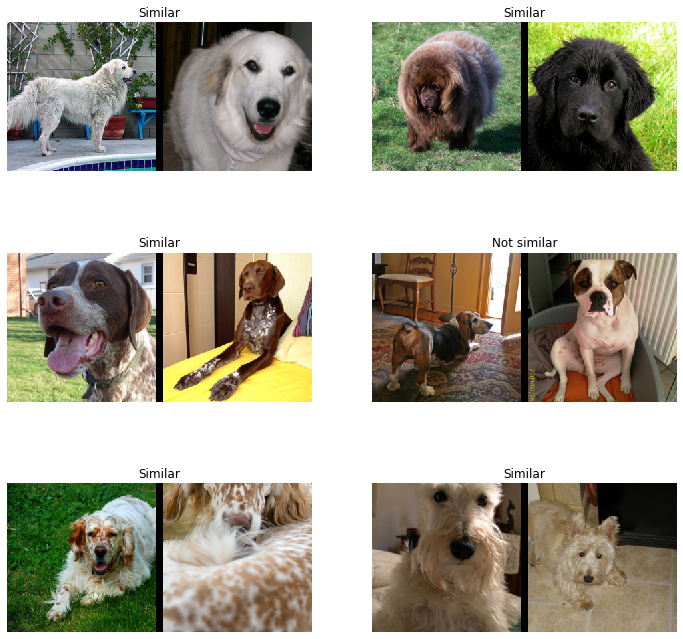

In [86]:
dls.show_batch()